# **Deep Q Network**

Deep Q Network is, like its name, based on q-learning and using deep neural network to update the Q-value and get the optimal policy; as a reault, DQN is also a value iteration method. Q-table is a key component of Q-learning; however it is limited to the state and action space, if there are infinite states or actions, it is hard to generate the Q-table. Deep Q Network overcomes this limitation by replacing Q-table with deep neural network to approximate the Q-value of each state-action pairs.


<img src="img/dqn.png" width="700">

Here are some key components in DQN:

1. **Q-value approximator**: as method above, DQN replaces Q-table by deep neural network, which is the Q-value approximator in DQN. The input of the network is the state, and the output is the set of Q-value of this state and possible actions.

2. **Experiment replay**: to stablize the learning process, DQN use a replay buffer to store one step experience (i.e. $S_{t},A_{t},R_{t},S{t+1}$). The network is trained on random mini-batches of experience from this buffer, breacking the correlation between consecutive experiences and improve efficiency.

3. **Target network**: target network is a copy of training network, but not updated every iteration to prevent rapid oscillations in learning.

4. **Bellman equation**: same as Q-learning, there is Bellman equation to update Q-value

$$Q(s,a)\leftarrow Q(s,a)+\alpha[r+\gamma\max_{a^{\prime}} Q(s^{\prime},a^{\prime};\theta^{-})-Q(s,a;\theta)]$$

where,   
$\theta$ is the weights of learning network.    
$\theta^{-}$ is weights of target networks.  

5. **Loss function**: recall that neural network need *loss* to update the weights, so we use the difference between Q-value from learning network and target network.  

Target Q-value $=\hat{q}=r+\gamma\max_{a^{\prime}} Q(s^{\prime},a^{\prime};\theta^{-})$   

Loss $=MSE(\hat{q},Q(s,a;\theta))$

<img src="img/dqn_flow.png" width="700">


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class network(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(network, self).__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        action = self.l3(x)
        return action
    

class DQN:
    def __init__(self, env, n_state, hidden_dim, n_action, lr=0.01, gamma = 0.99,epsilon = 1.0, batch_size = 32, target_replace_iter=100, memory_capacity=1e+10):
        self.env = env
        
        self.policy_net = network(n_state, hidden_dim, n_action)
        self.target_net = network(n_state, hidden_dim, n_action)
        
        self.memory_counter = 0
        self.learn_step_counter = 0
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.memory = []
        self.memory_capacity = memory_capacity
        self.target_replace_iter = target_replace_iter

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            action = self.policy_net(state).max(1)[1].item()
        return action
    
    def store_buffer(self, state, action, reward, next_state, done):
        if len(self.memory) < self.memory_capacity:
            self.memory.append((state, action, reward, next_state, done))
        else:
            self.memory = self.memory[1:] + [(state, action, reward, next_state, done)]
        self.memory_counter += 1

    def training(self):
        # Sample from buffer
        sample_idx = np.random.choice(len(self.memory), self.batch_size)
        batch_memory = [self.memory[i] for i in sample_idx]
        state_batch = torch.FloatTensor([m[0] for m in batch_memory])
        action_batch = torch.LongTensor([m[1] for m in batch_memory]).unsqueeze(1)
        reward_batch = torch.FloatTensor([m[2] for m in batch_memory]).unsqueeze(1)
        next_state_batch = torch.FloatTensor([m[3] for m in batch_memory])
        done_batch = torch.FloatTensor([m[4] for m in batch_memory]).unsqueeze(1)

        # Calculate Q value and loss
        q_learn = self.policy_net(state_batch).gather(1, action_batch)
        q_next = self.target_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        q_target = reward_batch + self.gamma * q_next * (1 - done_batch)
        loss = self.criterion(q_learn, q_target)

        # Update learning network weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Copy weights to target network every target_replace_iter
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_replace_iter == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            #print('Target network updated')

In [2]:
import gym

env = gym.make('CartPole-v1')

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
hidden_dim = 64

dqn = DQN(env, n_state, hidden_dim, n_action)

n_episodes = 3000

rewards = []
steps = []
for episode in range(n_episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    step = 0
    
    while not done:
        action = dqn.get_action(state)
        next_state, reward, done, _ = env.step(action)
        position, p_vel, angle, a_vel = next_state
        reward = -(abs(angle)/env.theta_threshold_radians + abs(position)/env.x_threshold + abs(p_vel) + abs(a_vel))  # Custom reward function
        dqn.store_buffer(state, action, -reward, next_state, done)
        state = next_state
        episode_reward += reward
        step += 1
        if len(dqn.memory) > dqn.batch_size:
            dqn.training()
    
    if episode % 10 == 0:
        dqn.epsilon = max(0.01, dqn.epsilon * 0.99)  # Decay epsilon
    if done:
        if episode % 200 == 0:
            print(f'Episode {episode} finished after {len(dqn.memory)} steps, total reward: {episode_reward/step}, actual reward: {step}')
        rewards.append(episode_reward/step)
        steps.append(step)

env.close()

/var/folders/69/6ry3j72176v59y5slnc712gw0000gn/T/ipykernel_5162/4234480435.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state_batch = torch.FloatTensor([m[0] for m in batch_memory])


Episode 0 finished after 53 steps, total reward: -1.2603385135561707, actual reward: 53
Episode 200 finished after 4790 steps, total reward: -2.1775909870614174, actual reward: 12
Episode 400 finished after 9925 steps, total reward: -1.1993394025368311, actual reward: 29
Episode 600 finished after 15068 steps, total reward: -2.6585115606987553, actual reward: 99
Episode 800 finished after 21943 steps, total reward: -1.478335491755112, actual reward: 20
Episode 1000 finished after 30562 steps, total reward: -1.5183215846108225, actual reward: 37
Episode 1200 finished after 39305 steps, total reward: -1.7963383175777834, actual reward: 108
Episode 1400 finished after 51232 steps, total reward: -1.8721858328088912, actual reward: 42
Episode 1600 finished after 63591 steps, total reward: -1.9066466694471544, actual reward: 13
Episode 1800 finished after 78384 steps, total reward: -2.0090542735241965, actual reward: 24
Episode 2000 finished after 93860 steps, total reward: -1.79279736362651

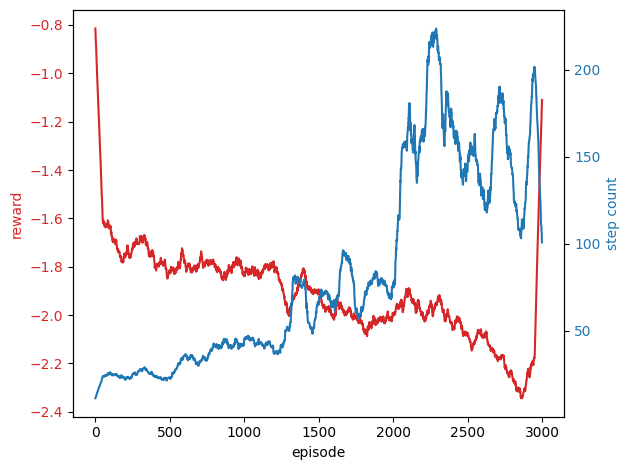

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

df = pd.DataFrame({'episode': range(n_episodes), 'reward': rewards, 'steps': steps})
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('episode')
ax1.set_ylabel('reward', color=color)
ax1.plot(df['episode'], smooth(df['reward'],100), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('step count', color=color)  # we already handled the x-label with ax1
ax2.plot(df['episode'], smooth(df['steps'],100), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Average test reward: -2.4365513796596407
Average test step count: 139.68


Text(0, 0.5, 'Frequency')

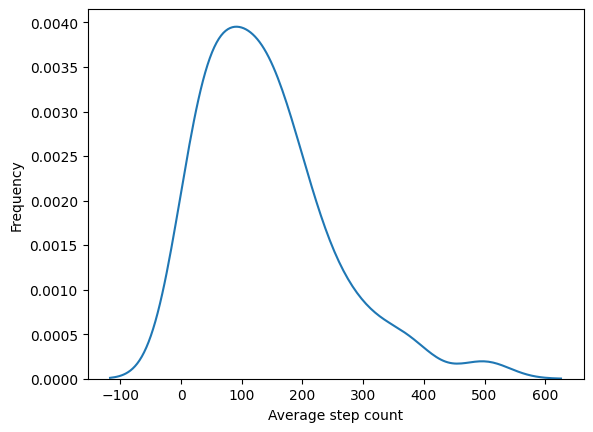

In [4]:
test_episodes = 100
test_rewards = []
test_steps = []
env = gym.make('CartPole-v1')

for episode in range(test_episodes):
    state = env.reset()
    episode_reward = 0
    step = 0
    done = False
    
    while not done:
        action = dqn.get_action(state)
        next_state, reward, done, _ = env.step(action)
        position, p_vel, angle, a_vel = next_state
        reward = -(abs(angle)/env.theta_threshold_radians + abs(position)/env.x_threshold + abs(p_vel) + abs(a_vel))  # Custom reward function
        episode_reward += reward
        step += 1
        state = next_state
    
    test_rewards.append(episode_reward/step)
    test_steps.append(step)
    #print(f'Test Episode {episode} finished with total reward: {episode_reward}')
env.close()


print('Average test reward:', np.mean(test_rewards))
print('Average test step count:', np.mean(test_steps))

import seaborn as sns
sns.kdeplot(test_steps,)
plt.xlabel('Average step count')
plt.ylabel('Frequency')

In [5]:
smooth(df['steps'],200)

array([ 11.86 ,  11.99 ,  12.085, ..., 102.145, 101.645, 101.07 ])